# <font color="red">Unzipping the Data</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train + validation data
!unzip /content/drive/MyDrive/Data_Science_Portfolio/BrainTumor_Detection/BrainTumorData.zip

In [ ]:
# completely unseen test data
!unzip /content/drive/MyDrive/Data_Science_Portfolio/BrainTumor_Detection/Prod_Testing_brain_tumor_dataset.zip

# <font color="red">Importing Libraries</font>

In [49]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import math
import seaborn as sns
from tensorflow.keras.callbacks import Callback,LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from prettytable import PrettyTable
import cv2
from tqdm import tqdm

# <font color="red">Some Initial investigation of the Images</font>

No. of tumor images=2513
No. of healthy images=2087
Different extensions of images are: ['tif', 'png', 'jpg', 'jpeg', 'JPG']

-------------------------------------------------------------------------

Tumor Scans:-
-----------------


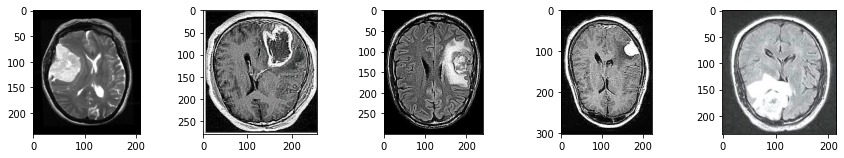


Healthy Scans:-
-----------------


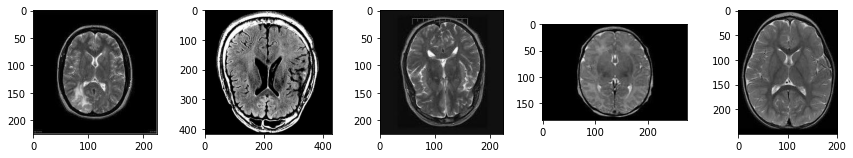

In [5]:
tumor_folder = "BrainTumorData/Brain Tumor Data Set/Brain Tumor"
healthy_folder = "BrainTumorData/Brain Tumor Data Set/Healthey"
tumor_listdir = os.listdir(tumor_folder)
healthy_listdir = os.listdir(healthy_folder)
print(f"No. of tumor images={len(tumor_listdir)}")
print(f"No. of healthy images={len(healthy_listdir)}")

tumor_img_extensions = list(set([img.split(".")[1] for img in tumor_listdir]))
healthy_img_extensions = list(set([img.split(".")[1] for img in healthy_listdir]))
diff_extensions = list(set(tumor_img_extensions+healthy_img_extensions))
print(f"Different extensions of images are: {diff_extensions}")
print()
print("-------------------------------------------------------------------------")
print()

# let's look at some tumorous and healthy MRI photos
def plot_photos(folder):
  images = os.listdir(folder)
  plt.subplots(figsize=(15, 5))
  # plot any 5 images
  for i in range(1,6):
    # define subplot
    plt.subplot(2,5,i)
    choice = random.randint(0,len(images)-1)
    chosenImg = images[choice]
    # define file path
    filename = folder + "/" + chosenImg
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
  # show the figure
  plt.show()
print("Tumor Scans:-")
print("-----------------")
plot_photos(tumor_folder)
print()
print("Healthy Scans:-")
print("-----------------")
plot_photos(healthy_folder)

In [6]:
# renaming properly since this is an entirely separate dataset
os.rename("/content/Prod_Testing_brain_tumor_dataset/no","/content/Prod_Testing_brain_tumor_dataset/healthy")

os.rename("/content/Prod_Testing_brain_tumor_dataset/yes","/content/Prod_Testing_brain_tumor_dataset/tumor")

In [7]:
test_tumor_listdir = os.listdir("/content/Prod_Testing_brain_tumor_dataset/tumor")
test_healthy_listdir = os.listdir("/content/Prod_Testing_brain_tumor_dataset/healthy")

print(f"No. of tumor images in test dataset={len(test_tumor_listdir)}")
print(f"No. of healthy images in test dataset={len(test_healthy_listdir)}")

No. of tumor images in test dataset=155
No. of healthy images in test dataset=98


# <font color="red">Creating Standard directories</font>

In [8]:
# moving all images (of both- tumor and healthy) together into a single temporary folder to further perform train-test split

# move tumor images first
shutil.copytree(tumor_folder, 'temp', shutil.move)

# move healthy images now
for file in healthy_listdir:
  src = healthy_folder+"/"+file
  shutil.copy(src,"temp")
  
# sanity check
print("Total No. of images in this temp folder=",len(os.listdir("temp")))

Total No. of images in this temp folder= 4600


In [9]:
#creating directories
parent = "tumor_vs_healthy/"
child_dirs = ["train/","validation/"]
for i in child_dirs:
  #create subdirectories for the 2 labels
  label_sub_dirs = ["tumor/","healthy"]
  for j in label_sub_dirs:
    newdir = parent + i + j
    os.makedirs(newdir,exist_ok=True)

# seed random number generator
random.seed(1)  # to get possible similar set of random numbers each time

# defining 80-20 ratio of train-validation split
val_ratio=0.20
# copy the images from temp folder into respective subdirectories for train and validation
src_directory = "temp"
for file in os.listdir(src_directory):
  s = src_directory + "/" + file
  dst_dir = "train/"
  if random.random() < val_ratio:
    dst_dir = "validation/"
  if file.startswith("Cancer"):
    d = parent + dst_dir + "tumor/" + file
    shutil.copyfile(s,d)
  elif file.startswith("Not Cancer"):
    d = parent + dst_dir + "healthy/" + file
    shutil.copyfile(s,d)

In [10]:
print("Sanity for no. of images in each folder:-")
print("train")
print("healthy-->",len(os.listdir("tumor_vs_healthy/train/healthy")))
print("tumor-->",len(os.listdir("tumor_vs_healthy/train/tumor")))
print("validation")
print("healthy-->",len(os.listdir("tumor_vs_healthy/validation/healthy")))
print("tumor-->",len(os.listdir("tumor_vs_healthy/validation/tumor")))

Sanity for no. of images in each folder:-
train
healthy--> 1676
tumor--> 1983
validation
healthy--> 411
tumor--> 530


# <font color="red">EDA & Pre-processing the Data</font>

### <b><font color="#66dd11">Basic EDA</font><b>

In [ ]:
# a simple EDA to get to know the height & width which have maximum no. of images
# using temp folder since all images are present here
parent = "/content/temp/"
all_heights = []
all_widths = []
for i in os.listdir(parent):
  filename = parent + i
  image = imread(filename)
  all_heights.append(image.shape[0])
  all_widths.append(image.shape[1])

Text(0.5, 6.799999999999997, 'Height')

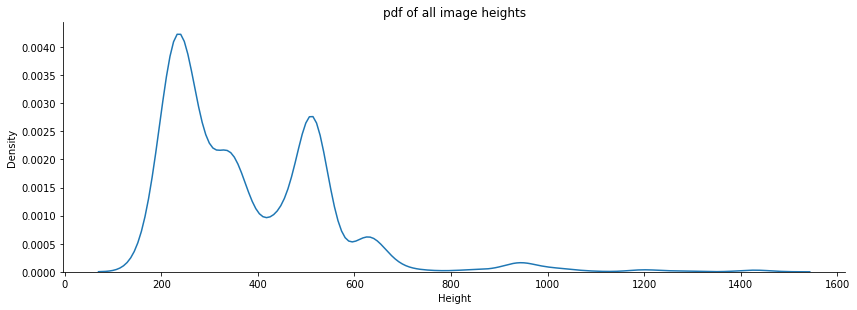

In [ ]:
sns.displot(data=all_heights,kind="kde",height=4,aspect=3)
plt.title("pdf of all image heights")
plt.xlabel("Height")

Text(0.5, 6.799999999999997, 'Width')

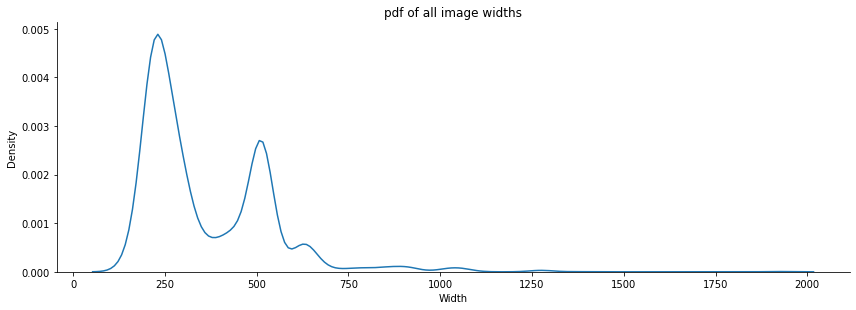

In [ ]:
sns.displot(data=all_widths,kind="kde",height=4,aspect=3)
plt.title("pdf of all image widths")
plt.xlabel("Width")

In [ ]:
# Most number of images have 250 as both height & width
# Hence, it will be better to keep target size of every image as (250,250) during pre-processing as shown below:-

In [11]:
# these folders are no longer required
shutil.rmtree("/content/BrainTumorData")
shutil.rmtree("/content/temp")

### <b><font color="#66dd11">Pre-processing Type-1</font><b>

In [12]:
BATCH_SIZE=32
TARGET_SIZE=(250,250)

# scaling the pixel values to the range 0-1 (data-normalization)
# creating the data generator
datagen1 = ImageDataGenerator(rescale=1/255)

# preparing iterators
path1 = "/content/tumor_vs_healthy/train"
train_it1 = datagen1.flow_from_directory(path1,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)
path2 = "/content/tumor_vs_healthy/validation"
validation_it1 = datagen1.flow_from_directory(path2,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)
path3 = "/content/Prod_Testing_brain_tumor_dataset"
test_it1 = datagen1.flow_from_directory(path3,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

print("Our data pre-processing is now done!")
print()
print("Checking the Binary Labels:-")
print(train_it1.class_indices,validation_it1.class_indices,test_it1.class_indices)

Found 3659 images belonging to 2 classes.
Found 941 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Our data pre-processing is now done!

Checking the Binary Labels:-
{'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1}


In [13]:
# just a sanity for deciding No. of batches or steps_per_epoch:-
print("No. of batches or steps_per_epoch for train set should be-->","3659/32=",3659/32,
      "i.e.",math.ceil(3659/32), ",which is simply", "len(train_it1)=",len(train_it1))
print("No. of batches or steps_per_epoch for validation set should be-->","941/32=",941/32,
      "i.e.",math.ceil(941/32), ",which is simply", "len(validation_it1)=",len(validation_it1))

No. of batches or steps_per_epoch for train set should be--> 3659/32= 114.34375 i.e. 115 ,which is simply len(train_it1)= 115
No. of batches or steps_per_epoch for validation set should be--> 941/32= 29.40625 i.e. 30 ,which is simply len(validation_it1)= 30


### <b><font color="#66dd11">Pre-processing Type-2</font><b>

In [14]:
BATCH_SIZE=32
TARGET_SIZE=(250,250)

# scaling the pixel values to the range 0-1 and augmenting:-
# (note: we'll augment the train data only. Not the validation/test data)
# rescaling will stay common in all 3 sets

# creating the train data generator 
datagen2 = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,
                              zoom_range=0.2,shear_range=0.2,horizontal_flip=True,
                              rescale=1/255)
# preparing train iterator
path1 = "/content/tumor_vs_healthy/train"
train_it2 = datagen2.flow_from_directory(path1,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

# creating the data generator for validation & test sets
datagen2 = ImageDataGenerator(rescale=1/255)
# preparing validation & test iterators
path2 = "/content/tumor_vs_healthy/validation"
validation_it2 = datagen2.flow_from_directory(path2,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)
path3 = "/content/Prod_Testing_brain_tumor_dataset"
test_it2 = datagen2.flow_from_directory(path3,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

print("Our data pre-processing is now done!")
print()
print("Checking the Binary Labels:-")
print(train_it2.class_indices,validation_it2.class_indices,test_it2.class_indices)

Found 3659 images belonging to 2 classes.
Found 941 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Our data pre-processing is now done!

Checking the Binary Labels:-
{'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1}


In [15]:
# just a sanity for deciding No. of batches or steps_per_epoch:-
print("No. of batches or steps_per_epoch for train set should be-->","3659/32=",3659/32,
      "i.e.",math.ceil(3659/32), ",which is simply", "len(train_it2)=",len(train_it2))
print("No. of batches or steps_per_epoch for validation set should be-->","941/32=",941/32,
      "i.e.",math.ceil(941/32), ",which is simply", "len(validation_it2)=",len(validation_it2))

No. of batches or steps_per_epoch for train set should be--> 3659/32= 114.34375 i.e. 115 ,which is simply len(train_it2)= 115
No. of batches or steps_per_epoch for validation set should be--> 941/32= 29.40625 i.e. 30 ,which is simply len(validation_it2)= 30


### <b><font color="#66dd11">Pre-processing Type-3</font><b>

In [16]:
BATCH_SIZE=32
TARGET_SIZE=(224,224) # since VGG16 expects this size of images

# scaling the pixel values to the range 0-1 and augmenting:-
# (note: we'll augment the train data only. Not the validation/test data)
# preprocessing_function will stay common in all 3 sets

# creating the train data generator 
datagen3 = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,
                              zoom_range=0.2,shear_range=0.2,horizontal_flip=True,
                              preprocessing_function=preprocess_input)
# preparing train iterator
path1 = "/content/tumor_vs_healthy/train"
train_it3 = datagen3.flow_from_directory(path1,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

# creating the data generator for validation & test sets
datagen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
# preparing validation & test iterators
path2 = "/content/tumor_vs_healthy/validation"
validation_it3 = datagen3.flow_from_directory(path2,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)
path3 = "/content/Prod_Testing_brain_tumor_dataset"
test_it3 = datagen3.flow_from_directory(path3,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

print("Our data pre-processing is now done!")
print()
print("Checking the Binary Labels:-")
print(train_it3.class_indices,validation_it3.class_indices,test_it3.class_indices)

Found 3659 images belonging to 2 classes.
Found 941 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Our data pre-processing is now done!

Checking the Binary Labels:-
{'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1} {'healthy': 0, 'tumor': 1}


In [17]:
# just a sanity for deciding No. of batches or steps_per_epoch:-
print("No. of batches or steps_per_epoch for train set should be-->","3659/32=",3659/32,
      "i.e.",math.ceil(3659/32), ",which is simply", "len(train_it3)=",len(train_it3))
print("No. of batches or steps_per_epoch for validation set should be-->","941/32=",941/32,
      "i.e.",math.ceil(941/32), ",which is simply", "len(validation_it3)=",len(validation_it3))

No. of batches or steps_per_epoch for train set should be--> 3659/32= 114.34375 i.e. 115 ,which is simply len(train_it3)= 115
No. of batches or steps_per_epoch for validation set should be--> 941/32= 29.40625 i.e. 30 ,which is simply len(validation_it3)= 30


# <font color="red">Defining Model Architectures & Evaluation<font>

### <b><font color="#66dd11">Re-usable functions & Keras Callbacks</font><b>

In [19]:
# function for plotting diagnostic curves --> a re-usable function
def summarize_diagnostics(history):
  plt.subplot(1,2,1)
  plt.title("Epoch vs Binary Cross Entropy Loss")
  plt.plot(history.history['loss'],color="blue",label="train")
  plt.plot(history.history['val_loss'],color="orange",label="test")
  plt.xlabel("Epoch")
  plt.legend()
  plt.subplot(1,2,2)
  plt.title("Epoch vs Accuracy")
  plt.plot(history.history['accuracy'],color="blue",label="train")
  plt.plot(history.history['val_accuracy'],color="orange",label="test")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

In [20]:
#callback to stop the training if your validation accuracy is not increased in last 2 epochs
# callback1 = EarlyStopping( monitor="val_accuracy",
#                            patience=5,
#                            verbose=1,
#                            mode="auto",
#                            min_delta=0)

#callback to decay learning based on below conditions 
#Cond1. If validation accuracy at that epoch is less than previous epoch accuracy, decrease the learning rate by 10%. 
#Cond2. For every 3rd epoch, decay learning rate by 5%
#for Cond1:-
# callback2 = ReduceLROnPlateau( monitor="val_accuracy",
#                               factor=0.1,
#                               patience=1,
#                               verbose=1,
#                               mode="auto"
#                               )
#for Cond2:-
def lf_schedule(epoch,lr):
  if epoch%10 ==0:
    lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
    print(f'New learning rate for epoch={epoch} is {lr}')
    return lr
  else:
    return lr
callback_lrs = LearningRateScheduler( schedule=lf_schedule,verbose=1 )

#callback to save the model at every epoch if validation accuracy is improved from previous epoch
#file path to save the best model for ModelCheckPoint:-
# !mkdir "model_save/"
# f_path = "model_save/best_model.h5"
# callback4 = ModelCheckpoint( filepath=f_path,
#                              monitor="val_accuracy",
#                              verbose=1,
#                              save_best_only=True,
#                              mode="auto"
#                            )

### <b><font color="#66dd11">Model-1 --> One block VGG (using Type-1 pre-processing)</font><b>

In [17]:
# defining 1st model architecture
model1=Sequential()
model1.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(250,250,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(units=128,activation="relu",kernel_initializer="he_uniform"))
model1.add(Dense(units=1,activation="sigmoid"))
# compile the model
model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 dense (Dense)               (None, 128)               64000128  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 64,001,153
Trainable params: 64,001,153
Non-trainable params: 0
____________________________________________

In [18]:
history1 = model1.fit(train_it1,steps_per_epoch=len(train_it1),
                     validation_data=validation_it1,validation_steps=len(validation_it1),
                     epochs=30,callbacks=[callback_lrs])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/30
115/115 [==============================] - 27s 161ms/step - loss: 4.9116 - accuracy: 0.7346 - val_loss: 1.3204 - val_accuracy: 0.8087 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/30
115/115 [==============================] - 16s 136ms/step - loss: 0.3282 - accuracy: 0.9063 - val_loss: 0.2036 - val_accuracy: 0.9256 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/30
115/115 [==============================] - 15s 134ms/step - loss: 0.0913 - accuracy: 0.9686 - val_loss: 0.4876 - val_accuracy: 0.8874 - lr: 9.5000e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 4/30
115/115 [==============================] - 16s 141ms/step - loss: 0.1371 - accuracy: 0.9544 - val_loss: 0.1756 -

Scanning the diagnostics of the model performance:-


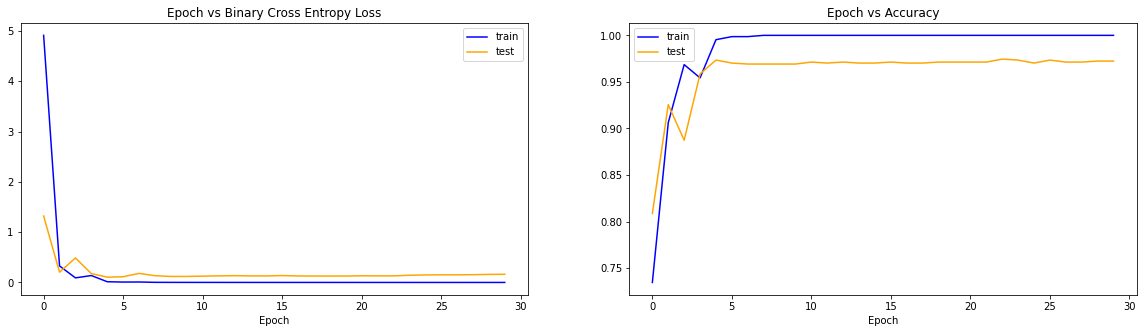

In [19]:
print("Scanning the diagnostics of the model performance:-")
plt.subplots(figsize=(20, 5))
summarize_diagnostics(history1)

In [20]:
_,acc = model1.evaluate(test_it1,steps=len(test_it1))
print("Evaluation Accuracy on completely unseen test data-set=",np.round(acc*100,3),"%")

8/8 [==============================] - 1s 120ms/step - loss: 0.0788 - accuracy: 0.9960
Evaluation Accuracy on completely unseen test data-set= 99.605 %


### <b><font color="#66dd11">Model-2 --> Three Block VGG + Dropout Regularization (using Type-1 pre-processing)</font></b>

In [21]:
# defining 2nd model architecture
model2=Sequential()
model2.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(250,250,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))
model2.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(units=128,activation="relu",kernel_initializer="he_uniform"))
model2.add(Dense(units=1,activation="sigmoid"))
# compile the model
model2.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 125, 125, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

In [22]:
history2 = model2.fit(train_it1,steps_per_epoch=len(train_it1),
                      validation_data=validation_it1,validation_steps=len(validation_it1),
                      epochs=30,callbacks=[callback_lrs])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/30
115/115 [==============================] - 23s 122ms/step - loss: 2.1996 - accuracy: 0.6876 - val_loss: 0.4744 - val_accuracy: 0.8130 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/30
115/115 [==============================] - 14s 118ms/step - loss: 0.3706 - accuracy: 0.8415 - val_loss: 0.3679 - val_accuracy: 0.8459 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/30
115/115 [==============================] - 15s 134ms/step - loss: 0.2325 - accuracy: 0.9128 - val_loss: 0.2078 - val_accuracy: 0.9362 - lr: 9.5000e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 4/30
115/115 [==============================] - 15s 128ms/step - loss: 0.1425 - accuracy: 0.9486 - val_loss: 0.1458 -

Scanning the diagnostics of the model performance:-


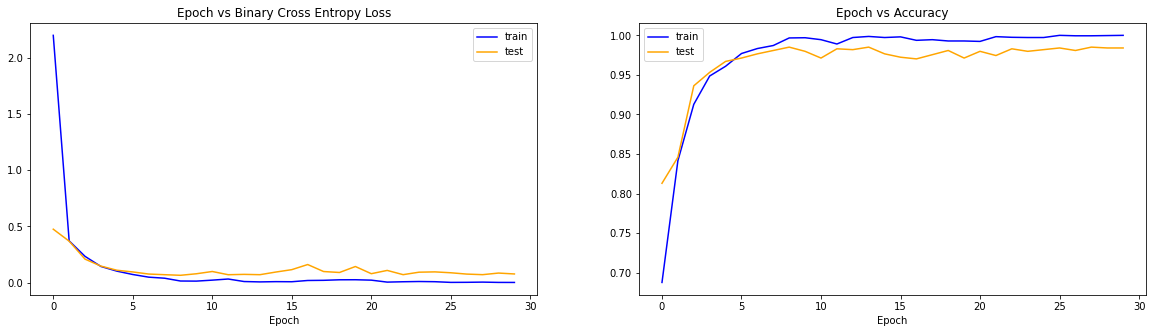

In [23]:
print("Scanning the diagnostics of the model performance:-")
plt.subplots(figsize=(20, 5))
summarize_diagnostics(history2)

In [24]:
_,acc = model2.evaluate(test_it1,steps=len(test_it1))
print("Evaluation Accuracy on completely unseen test data-set=",np.round(acc*100,3),"%")

8/8 [==============================] - 1s 122ms/step - loss: 0.0274 - accuracy: 0.9960
Evaluation Accuracy on completely unseen test data-set= 99.605 %


### <b><font color="#66dd11">Model-3 --> Three Block VGG + Dropout Regularization + Image Data Augmentation (using Type-2 pre-processing)</font></b>

In [25]:
# defining 3rd model architecture

model3=Sequential()
model3.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(250,250,3)))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))
model3.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(units=128,activation="relu",kernel_initializer="he_uniform"))
model3.add(Dense(units=1,activation="sigmoid"))
# compile the model
model3.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 125, 125, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 64)       

In [26]:
history3 = model3.fit(train_it2,steps_per_epoch=len(train_it2),
                     validation_data=validation_it2,validation_steps=len(validation_it2),
                     epochs=30,callbacks=[callback_lrs])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/30
115/115 [==============================] - 51s 442ms/step - loss: 1.9258 - accuracy: 0.5901 - val_loss: 0.6281 - val_accuracy: 0.6748 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/30
115/115 [==============================] - 51s 440ms/step - loss: 0.6086 - accuracy: 0.6789 - val_loss: 0.5755 - val_accuracy: 0.7301 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/30
115/115 [==============================] - 51s 439ms/step - loss: 0.5772 - accuracy: 0.7087 - val_loss: 0.5554 - val_accuracy: 0.7184 - lr: 9.5000e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 4/30
115/115 [==============================] - 50s 439ms/step - loss: 0.5373 - accuracy: 0.7376 - val_loss: 0.5310 -

Scanning the diagnostics of the model performance:-


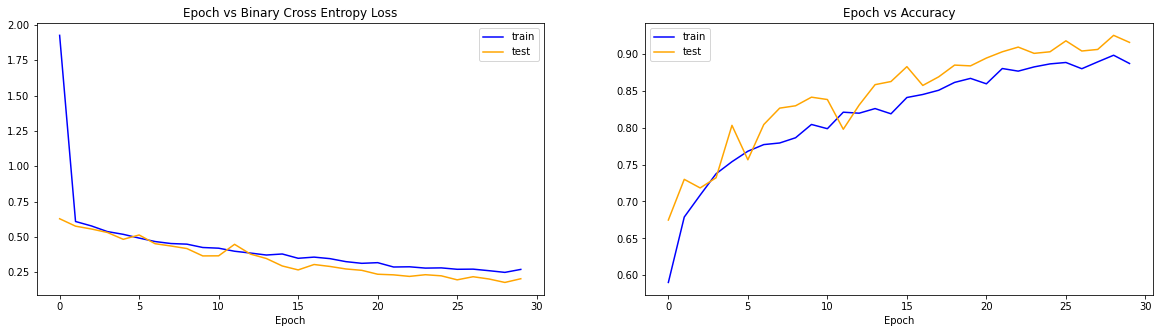

In [27]:
print("Scanning the diagnostics of the model performance:-")
plt.subplots(figsize=(20, 5))
summarize_diagnostics(history3)

In [28]:
_,acc = model3.evaluate(test_it2,steps=len(test_it2))
print("Evaluation Accuracy on completely unseen test data-set=",np.round(acc*100,3),"%")

8/8 [==============================] - 1s 98ms/step - loss: 0.2362 - accuracy: 0.9051
Evaluation Accuracy on completely unseen test data-set= 90.514 %


### <b><font color="#66dd11">Model-4 --> Transfer Learning for Feature Extraction via VGG16 + Data Augmentation (using Type-3 pre-processing)</font></b>

In [58]:
tf.keras.backend.clear_session()
# defining 1st model architecture

# loading the base-model
model4=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
# mark the loaded layers as not-trainable
for layer in model4.layers:
  layer.trainable=False
# adding new classifier layers
flat = Flatten()(model4.layers[-1].output)
classifier = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(flat)
output = Dense(units=1,activation="sigmoid")(classifier)
# define the model
model4 = Model(inputs=model4.inputs,outputs=output)
# compile the model
model4.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [59]:
history4 = model4.fit(train_it3,steps_per_epoch=len(train_it3),
                      validation_data=validation_it3,validation_steps=len(validation_it3),
                      epochs=30)

Epoch 1/30
115/115 [==============================] - 45s 388ms/step - loss: 2.8331 - accuracy: 0.8584 - val_loss: 1.1614 - val_accuracy: 0.9097
Epoch 2/30
115/115 [==============================] - 45s 389ms/step - loss: 0.6008 - accuracy: 0.9169 - val_loss: 0.1479 - val_accuracy: 0.9522
Epoch 3/30
115/115 [==============================] - 44s 380ms/step - loss: 0.1972 - accuracy: 0.9410 - val_loss: 0.0926 - val_accuracy: 0.9756
Epoch 4/30
115/115 [==============================] - 43s 378ms/step - loss: 0.1356 - accuracy: 0.9549 - val_loss: 0.0673 - val_accuracy: 0.9745
Epoch 5/30
115/115 [==============================] - 44s 380ms/step - loss: 0.1139 - accuracy: 0.9609 - val_loss: 0.0991 - val_accuracy: 0.9681
Epoch 6/30
115/115 [==============================] - 44s 381ms/step - loss: 0.0807 - accuracy: 0.9721 - val_loss: 0.0513 - val_accuracy: 0.9819
Epoch 7/30
115/115 [==============================] - 44s 382ms/step - loss: 0.0856 - accuracy: 0.9697 - val_loss: 0.0644 - val_ac

Scanning the diagnostics of the model performance:-


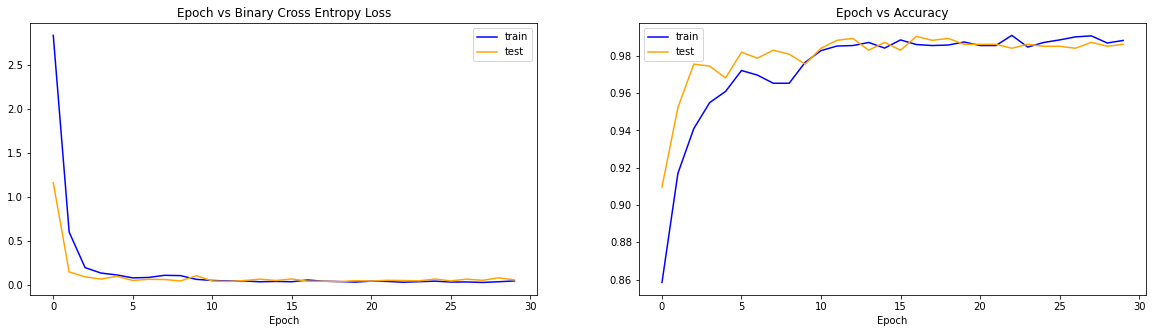

In [60]:
print("Scanning the diagnostics of the model performance:-")
plt.subplots(figsize=(20, 5))
summarize_diagnostics(history4)

In [61]:
_,acc = model4.evaluate(test_it3,steps=len(test_it3))
print("Evaluation Accuracy on test data-set=",np.round(acc*100,3),"%")

8/8 [==============================] - 1s 104ms/step - loss: 0.0066 - accuracy: 0.9960
Evaluation Accuracy on test data-set= 99.605 %


In [63]:
model4.save("/content/drive/MyDrive/Data_Science_Portfolio/BrainTumor_Detection/save_model4.h5",save_format="h5")

### <b><font color="#66dd11">Model-5 --> Transfer Learning for Feature Extraction via VGG16 + Data Augmentation (using Type-3 pre-processing)</font></b>

In [52]:
tf.keras.backend.clear_session()
# defining 1st model architecture

# loading the base-model
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

# mark the loaded layers as not-trainable
for layer in base_model.layers:
  layer.trainable=False

# adding new classifier layers
flat = Flatten()(base_model.get_layer('block3_pool').output)
dense1 = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(flat)
drp = Dropout(0.3)(dense1)
dense2 = Dense(units=64,activation='relu',kernel_initializer="he_uniform")(drp)
dense3 = Dense(units=32,activation='relu',kernel_initializer="he_uniform")(dense2)
output = Dense(units=1,activation="sigmoid")(dense3)

# define the model
model5 = Model(inputs=base_model.inputs,outputs=output)

# compile the model
model5.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [53]:
history5 = model5.fit(train_it3,steps_per_epoch=len(train_it3),
                      validation_data=validation_it3,validation_steps=len(validation_it3),
                      epochs=30,callbacks=[callback_lrs])

New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/30
115/115 [==============================] - 45s 384ms/step - loss: 3150.9065 - accuracy: 0.5622 - val_loss: 146.6015 - val_accuracy: 0.6982 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/30
115/115 [==============================] - 44s 381ms/step - loss: 136.7216 - accuracy: 0.6002 - val_loss: 14.6266 - val_accuracy: 0.5930 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/30
115/115 [==============================] - 44s 379ms/step - loss: 2.6771 - accuracy: 0.5395 - val_loss: 0.6174 - val_accuracy: 0.5983 - lr: 9.5000e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 4/30
115/115 [==============================] - 44s 379ms/step - loss: 0.7877 - accuracy: 0.5570 - val_loss: 

Scanning the diagnostics of the model performance:-


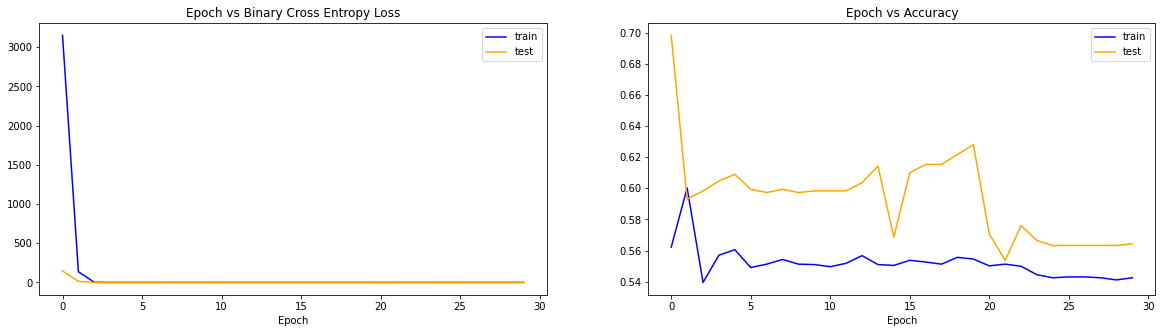

In [54]:
print("Scanning the diagnostics of the model performance:-")
plt.subplots(figsize=(20, 5))
summarize_diagnostics(history5)

In [56]:
_,acc = model5.evaluate(test_it3,steps=len(test_it3))
print("Evaluation Accuracy on test data-set=",np.round(acc*100,3),"%")

8/8 [==============================] - 1s 106ms/step - loss: 0.6812 - accuracy: 0.6206
Evaluation Accuracy on test data-set= 62.055 %


In [ ]:
# model5.save("/content/drive/MyDrive/Data_Science_Portfolio/BrainTumor_Detection/save_model5",save_format="h5")

# <font color="red">Making a few Sample Predictions</font>

In [66]:
def predict_tumor(img_path):
    # load the image
    img = load_img(img_path, target_size=(224, 224))  #(224,224,3)
    plt.imshow(img)
    # convert to array
    img = img_to_array(img) #(224,224,3)
    # add batch size as a dimension 
    img = np.expand_dims(img, axis=0)  #(1,224,224,3)
    best = load_model("/content/drive/MyDrive/Data_Science_Portfolio/BrainTumor_Detection/save_model4.h5")
    if best.predict(img)[0][0]>0.4:
        print("The image indicates presence of Brain tumor")
    else:
        print("This is a Healthy Brain")
    print("Probability of classfication:",best.predict(img)[0][0])

The image indicates presence of Brain tumor
Probability of classfication: 1.0


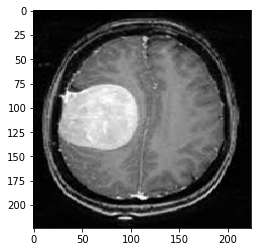

In [67]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/tumor/Y1.jpg")

This is a Healthy Brain
Probability of classfication: 6.1865553e-06


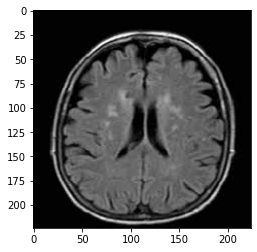

In [68]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/healthy/17 no.jpg")

The image indicates presence of Brain tumor
Probability of classfication: 1.0


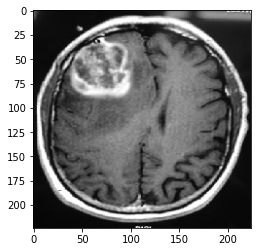

In [69]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/tumor/Y181.jpg")

The image indicates presence of Brain tumor
Probability of classfication: 0.9999076


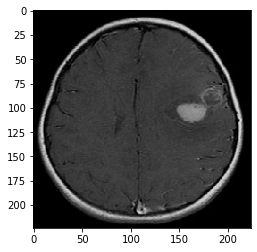

In [70]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/tumor/Y31.jpg")

This is a Healthy Brain
Probability of classfication: 0.0001492912


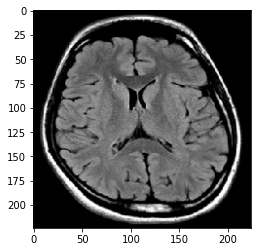

In [71]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/healthy/no 95.jpg")

This is a Healthy Brain
Probability of classfication: 0.0034634974


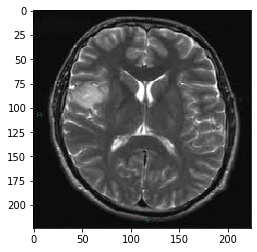

In [72]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/tumor/Y187.jpg")

In [ ]:
# the above is incorrect
# or mis-labelling may have occurred

The image indicates presence of Brain tumor
Probability of classfication: 0.9999751


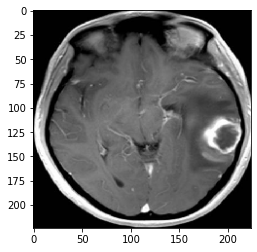

In [73]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/tumor/Y154.jpg")

This is a Healthy Brain
Probability of classfication: 4.899613e-13


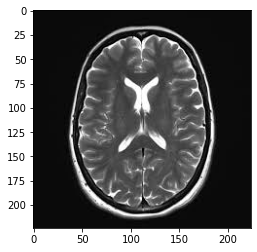

In [74]:
predict_tumor("/content/Prod_Testing_brain_tumor_dataset/healthy/39 no.jpg")

# <font color="red">Summarization</font>

In [65]:
x = PrettyTable(["Model Architecture","Completely Unseen Test Data Accuracy"])
x.add_row([" Model-1: One block VGG ", "99.605%"])
x.add_row([" Model-2: Three Block VGG + Dropout Regularization ", "99.605 %"])
x.add_row([" Model-3: Three Block VGG + Dropout Regularization + Image Data Augmentation ", "90.514 %"])
x.add_row([" Model-4: Transfer Learning for Feature Extraction from block4_pool (MaxPooling2D) via VGG16 + Data Augmentation ", "99.605 %"])
x.add_row([" Model-4: Transfer Learning for Feature Extraction from block3_pool (MaxPooling2D) via VGG16 + Data Augmentation ", "62.055 %"])
print(x)

+-------------------------------------------------------------------------------------------------------------------+--------------------------------------+
|                                                 Model Architecture                                                | Completely Unseen Test Data Accuracy |
+-------------------------------------------------------------------------------------------------------------------+--------------------------------------+
|                                               Model-1: One block VGG                                              |               99.605%                |
|                                 Model-2: Three Block VGG + Dropout Regularization                                 |               99.605 %               |
|                    Model-3: Three Block VGG + Dropout Regularization + Image Data Augmentation                    |               90.514 %               |
|  Model-4: Transfer Learning for Feature Extraction from 

In [ ]:
# References:-
# Dataset Credits: 
# For train and test --> Edureka--> https://www.youtube.com/watch?v=7MceDfpnP8k
# For validation --> https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

# https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
# https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
# https://github.com/keras-team/keras/issues/5862#issuecomment-647559571
# https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [ ]:
# balanced dataset --> accuracy best metric
# tweaked around on the actual article by working on the future works mentioned
# small dataset & hence adding high dropout of 0.5 especially at later layers is not quite desirable
# inception / resnet